In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#import xgboost as xgb

In [21]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('submission.csv')

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [23]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [24]:
"""결측치 작업"""

train=train.drop(['dir_prev_bfnum'], axis=1)
test=test.drop(['dir_prev_bfnum'], axis=1)
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0,431,4,2192525


In [25]:
"""영향력 없는 데이터 제거"""
train=train.drop(['director'], axis=1)
test=test.drop(['director'], axis=1)
train=train.drop(['title'], axis=1)
test=test.drop(['title'], axis=1)


In [26]:
train.distributor.value_counts()

distributor
CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: count, Length: 169, dtype: int64

In [27]:
distributor_list=train.distributor.value_counts()[:5] #상위 5개만 추출

def apple(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return 'etc'

train['distributor']=train['distributor'].apply(apple) #배급사 항목에 상위 5개만 남기고 나머지는 etc로 변경
test['distributor']=test['distributor'].apply(apple)

In [31]:
"""파생변수 생성"""
def movie_year(release_time):
    return int(release_time[:4])

def movie_month(release_time):
    return int(release_time[5:7])

#적용
train['년'] = train['release_time'].apply(movie_year)
test['년'] = test['release_time'].apply(movie_year)

train['월'] = train['release_time'].apply(movie_month)
test['월'] = test['release_time'].apply(movie_month)

#release_time 제거
train=train.drop(['release_time'], axis=1)
test=test.drop(['release_time'], axis=1)


In [33]:
""" 더미변수 생성"""
#원핫 인코딩?
train=pd.get_dummies(train)
test=pd.get_dummies(test)

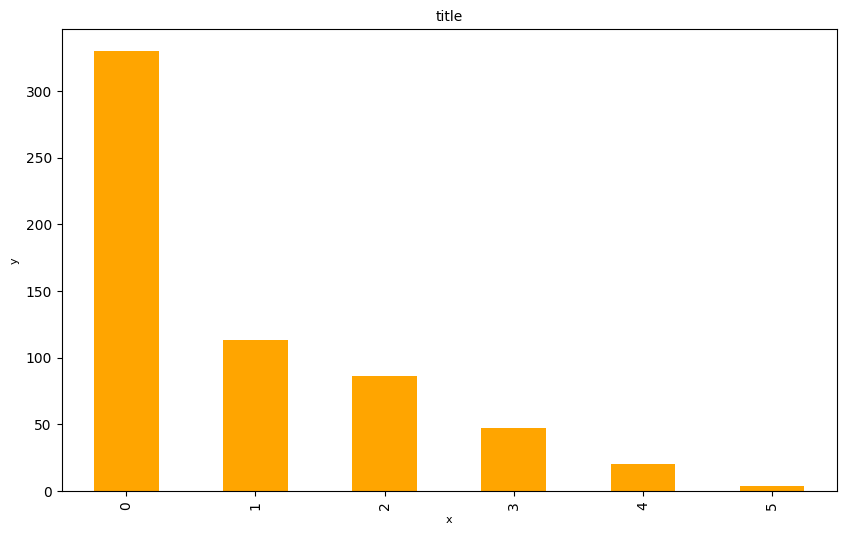

In [ ]:
import matplotlib.pyplot as plt

dir_prev_num_counts=train['dir_prev_num'].value_counts()
plt.figure(figsize=(10,6))
dir_prev_num_counts.plot(kind='bar', color='orange')
plt.title('title', fontsize=10)
plt.xlabel('x', fontsize=8)
plt.ylabel('y', fontsize=8)
plt.show()

In [34]:
"""모델링"""

train_x=train.drop(['box_off_num'], axis=1)
train_y=train['box_off_num']
test_x=test #test는 box_off_num이 없음

model=RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_x, train_y)

RandomForestRegressor(random_state=42)

In [38]:
"""모델 평가"""

# RMSE 함수 정의
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 훈련 데이터 성능 평가
train_pred = model.predict(train_x)  # 훈련 데이터 예측값
train_rmse = rmse(train_y, train_pred)
print("Train RMSE:", train_rmse)

pred=model.predict(test)
submission['box_off_num']=pred
submission.to_csv('submission.csv', index=False)

Train RMSE: 579000.2582708601


In [39]:
print(model.score(train_x, train_y))

0.8995090897988481
